In [13]:
from sotodlib import core, io

import datetime as dt

import numpy as np
import dill as pk

import h5py
from optical_loading import pwv_interp


In [22]:
pwv = pwv_interp()

In [15]:
with open("results_05012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)


In [158]:
ctx = core.Context('./smurf_det_preproc.yaml')

start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,4,28, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='obs' and subtype=='cmb'"
)

In [159]:
net_dict = {}

for key in abscal_dict.keys():
    ufm = key.split("_")[4]
    freq = key.split("_")[5]
    if ufm in abscal_dict.keys():
        continue
    if "090" in freq or "150" in freq:
        net_dict[ufm] = {"090":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}, "150":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}}
    else:
        net_dict[ufm] = {"220":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}, "280":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}}

In [160]:
cur_obs = obs_list[1]
wafers = cur_obs["stream_ids_list"].split(",")
cur_wafer = wafers[0].split("_")[-1]

try:
    meta = ctx.get_meta(cur_obs["obs_id"])
except:
    print("No meta data for obs {}".format(cur_obs["obs_id"]))


In [164]:
wafer_flag = np.array([cur_wafer in ufm for ufm in meta.det_info.stream_id])


In [86]:
ufm_band = 1
if "mv" in cur_wafer:
    if ufm_band == 1:
        band = "090"
    elif ufm_band == 2:
        band = "150"
if "uv" in cur_wafer:
    if ufm_band == 1:
        band = "220"
    elif ufm_band == 2:
        band = "280"


wafer_flag = np.array([cur_wafer in ufm for ufm in meta.det_info.stream_id])

bp = (meta.det_cal.bg % 4) // 2

if ufm_band == 1:
    net_flag = wafer_flag * (bp==0)
elif ufm_band == 2:
    net_flag = wafer_flag * (bp==1)

try:
    times = np.array([float(label.split("_")[0]) for label in result_dict[cur_wafer][band]["obs"]])
except KeyError:
    continue
    
closest_idx = np.argmin(np.abs(times-cur_obs["timestamp"]))
closest_obs = times[closest_idx]
closest_chi = result_dict[cur_wafer][band]["chi"][closest_idx]
if np.abs(times[5]-cur_obs["timestamp"])/3600 < 24 and 25 <= closest_chi and closest_chi < 1000 : #If most recent obs within a day
    raw_cal = result_dict[cur_wafer][band]["raw_cal"][closest_idx]
    chisq = closest_chi
else:
    raw_cal = np.mean(result_dict[cur_wafer][band]["raw_cal"])
    chisq = 999999
ndets = len(np.where((meta.preprocess.noise.white_noise[net_flag] != 0))[0])

net_mes = 1/np.sqrt(2) * meta.preprocess.noise.white_noise[net_flag] * raw_cal * meta.det_cal.phase_to_pW[net_flag]
clean_nets = []
for net in net_mes:
    if net*1e6 >= 125:
        clean_nets.append(net)
clean_nets = np.array(clean_nets)
array_net = np.nansum((clean_nets*1e6)**(-2))**(-1/2)

In [87]:
net_dict[cur_wafer][band]["raw_cal"].append(raw_cal)
net_dict[cur_wafer][band]["chi"].append(chisq)
net_dict[cur_wafer][band]["obs"].append(cur_obs["obs_id"])
net_dict[cur_wafer][band]["ndets"].append(ndets)
net_dict[cur_wafer][band]["nets"].append(array_net)
net_dict[cur_wafer][band]["el"].append(result_dict[cur_wafer][band]["el"])
net_dict[cur_wafer][band]["pwv"].append(result_dict[cur_wafer][band]["pwv"])

In [88]:
result_dict.keys()

dict_keys(['uv47', 'uv31', 'uv39', 'uv38', 'mv13', 'mv20', 'mv14', 'mv49', 'mv25', 'mv21', 'mv24'])

# Plotting

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

with open("nets.pk", "rb") as f:
    net_dict = pk.load(f)

In [23]:
labels = []
nets = []
chis = []
obs = []
pwvs = []
ndets = []

freqs = ["090", "150"]#, "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_chis = np.array(net_dict[key][sub_key]["chi"])
                #flags = np.where((25<= cur_chis) & (cur_chis<=1000))[0]
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                #cur_chis = cur_chis[flags]
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_nets)):
                    cur_pwv = pwv(cur_obs[j].split("_")[1])
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100 and cur_pwv < 3: #very large nets are not real
                        nets.append(cur_nets[j])
                        labels.append(label)
                        chis.append(cur_chis[j])
                        obs.append(cur_obs[j])
                        pwvs.append(cur_pwv)
                        ndets.append(cur_ndets[j])
                    
labels = np.array(labels)
nets = np.array(nets)
chis = np.array(chis)
obs = np.array(obs)
pwvs = np.array(pwvs)
ndets = np.array(ndets)

df = pd.DataFrame({'labels': labels, 'nets': nets, 'chis': chis, 'obs': obs, "ndets":ndets, "pwv":pwvs})

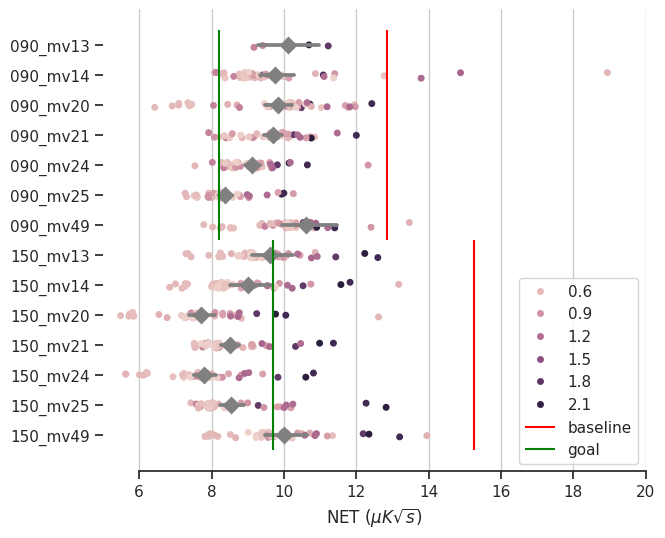

In [24]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation
sns.pointplot(data=df, x="nets", y="labels", linestyle="none", marker="D", color="0.5", zorder=2)
sns.stripplot(df, x="nets", y="labels", hue="pwv", zorder=1)



ymax, ymin = ax.get_ylim()
plt.vlines(4.01*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="baseline", color="red")
plt.vlines(2.56*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="goal", color="green")

plt.vlines(4.76*np.sqrt(12)/1.08, ymin = 6.5, ymax = ymax, label=None, color="red")
plt.vlines(3.02*np.sqrt(12)/1.08, ymin = 6.5, ymax = ymax, label=None, color="green")
"""
plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_1"]["dpdt_rj"])), ymin = 13.5, ymax = 17.5, label=None, color="red")
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_1"]["dpdt_rj"])), ymin = 13.5, ymax = 17.5, label=None, color="green")

plt.vlines(1.0/(1e12*(sim["UHF"]["baseline"]["UHF_2"]["dpdt_rj"])), ymin = 17.5, ymax = ymax, label=None, color="red")
plt.vlines(1.0/(1e12*(sim["UHF"]["goal"]["UHF_2"]["dpdt_rj"])), ymin = 17.5, ymax = ymax, label=None, color="green")
"""

plt.xlim(5, 20)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="NET ($\mu K \sqrt{s}$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/nets/nets.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/nets.png", dpi=600, bbox_inches='tight')